# Intro / Goals / Context


## Goal: 

Predict the fare of taxi tours

Is this a meaningful goal, or some placeholder task to do something?

## Question to Public:

" What kind of feature do you think necessary to have?"

" Why is this a datascience question?"

  - Uncertainty about the driver


# Motivation for the workshop?


What makes spatial data special? 
What kind of novel problems we face by working with spatial data?

    
    * COMPUTING DISTANCES: understand the spatial data properties (e.g. lat/lon, geodesical view)
    
    * being able to VISUALISE these datasets
        * plot heat maps on geographical backgrounds
        
    * ROUNDING must respect the architecture of the city, roads and building (example: route tracing should turn around the buildings).
    
    
    
# Modelling

## Get data and make exploratory plots to clean it.

* Use Kepler on cleaned data and develop a nice intuition.

## Baseline Model 00 (SO + CM)

* Explain Euclidean distance
* predict fare using the Euclidean distance
    Fare ~ 1 + EuclideanDistance
* Discuss what is the problem with the Euclidean distance.
    * TEACHING: Different types of distances
    * Have function definitions for different types of distances, explain code.
* Run the same model with different types of distances, and evaluate how much better the model becomes...
    Fare ~ 1 + X_Distance
    
## Updated Model 01 (EJ)

* use H3 hexagones as categorical features with the idea of capturing systematic variations in locations e.g. center of the city being more busy in general in comparison to a tour along the periphery of the city.


* demand within an hexagon.


## Updated Model 02 

* Daily seasonality: hour of the day as a feature with the idea 
    
    
## Updated Model 03 (CM)

Use https://osmcode.org/pyosmium/ to get route features.

* Get features from the route between pickup and dropoff
  ** # of traffic lights
  ** Allowed speed limit
  ** Number of lanes
  ** Number of hard lefts


## DISCUSSION

how to incorporate traffic information?


# (QUESTIONS for us) /

* do we want to train the model on all train data: Memory considerations


* Why is this task meaningful? 
    ** A simple rule is generating these data, why do we need data science to recover a known rule?
    
    ** how is what we want to do different than applying the rule that generates taxi fares?
    
    
* Are we going to train the model on the fly? If so, how long does it to fit it to 50 millions data points.


    

In [1]:
# %pip install pyproj

In [2]:
# libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import keplergl
import pickle
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from geopandas import GeoSeries

from utils.osrm_router.OSRMFramework import OSRMFramework
from utils.visualisation.lines import plot_linestring
from utils.geometry.conversor import latlon2linestring

###### constants
TARGET = 'fare_amount'
OSRM_PATH = 'localhost:5000'


In [3]:
# df = pd.read_csv('https://raw.githubusercontent.com/caiomiyashiro/geospatial_data_analysis/master/data/sample_100000.csv')
df = pd.read_csv('data/sample_100000.csv')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
display(df.head())
display(df.dtypes)


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,8.1,2009-01-23 07:28:00,-73.996070,40.732605,-73.980675,40.761864,1
1,9.0,2014-01-04 21:11:00,-73.977640,40.752346,-73.970390,40.768867,2
2,6.5,2015-06-22 01:54:24,-74.000080,40.728610,-73.988730,40.722170,6
3,4.5,2010-11-24 12:46:52,-73.962685,40.775646,-73.957436,40.777767,1
4,4.5,2011-11-01 02:19:34,-73.996300,40.753600,-73.998800,40.761100,1


fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

# First Analysis

## check amount of NaN - just remove them

In [4]:
# check amount of NaN - just remove them
display(df.drop('pickup_datetime',axis=1).apply(lambda col: np.sum(np.isnan(col)), axis=0))

df = df.loc[(~np.isnan(df['dropoff_latitude'])) & ~np.isnan(df['dropoff_longitude'])]

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    3
dropoff_latitude     3
passenger_count      0
dtype: int64

## Check pickup points

In [5]:
w1 = keplergl.KeplerGl(height=500)
w1.add_data(data=df[['pickup_latitude', 'pickup_longitude',
                     'dropoff_latitude', 'dropoff_longitude']], name='points')
w1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'points': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …

In [6]:
def remove_outside_bbox(df, bbox, lat_col, lon_col):
    df_ = df.copy()
    mask_lat = (df_[lat_col] > bbox[0][0]) & (df_[lat_col] < bbox[1][0])
    mask_lon = (df_[lon_col] > bbox[0][1]) & (df_[lon_col] < bbox[1][1])
    return df_.loc[(mask_lat) & (mask_lon)]

bottom_left_lat_lon = [40.492016, -74.279034]
upper_right_lat_lon = [40.913473, -73.689152]
bbox = [bottom_left_lat_lon, upper_right_lat_lon]

df = remove_outside_bbox(df, bbox, 'pickup_latitude', 'pickup_longitude')
df = remove_outside_bbox(df, bbox, 'dropoff_latitude', 'dropoff_longitude')

w1 = keplergl.KeplerGl(height=500)
w1.add_data(data=df[['pickup_latitude', 'pickup_longitude',
                     'dropoff_latitude', 'dropoff_longitude']], name='points')
w1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'points': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, …

## Check impossible fares

Note that we're removing only impossible fares for now. Any filter based on value distribution should be done only using the training set.

In [7]:
display(df['fare_amount'].describe())
print('')

fare_under_0 = np.sum(df['fare_amount']<0)
print(f'{fare_under_0} rows with fare under 0')

df = df.loc[df['fare_amount'] > 0]

count    97734.000000
mean        11.243156
std          9.432648
min        -10.100000
25%          6.000000
50%          8.500000
75%         12.500000
max        500.000000
Name: fare_amount, dtype: float64


8 rows with fare under 0


# Split training and testing before analysis

In [8]:
def split_training_test(df, target=TARGET, test_size=0.2):
    X = df.drop(TARGET, axis=1)
    y = df[TARGET]
    return train_test_split(X, y, test_size=test_size, random_state=0) 

def join_Xy(df, target, target_str=TARGET):
    df_ = df.copy()
    df_[target_str] = target
    return df_

def get_initial_training_testing_set(df):
    X_train, X_test, y_train, y_test = split_training_test(df)
    print(f'Shape X_train {X_train.shape}')
    print(f'Shape X_test {X_test.shape}')

    # join target for easier exploratory analysis
    df_train = join_Xy(X_train, y_train)
    df_test = join_Xy(X_test, y_test)
    return df_train, df_test

df_train, df_test = get_initial_training_testing_set(df)

Shape X_train (78178, 6)
Shape X_test (19545, 6)


# Data Analysis

Only training data that will be used for training

## Remove fares < minimum fare and outliers > 99th percentile

In [9]:
# minimum fare: https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

display(df_train['fare_amount'].describe(percentiles=[.01, .05, .1, .90,.95,.99]))
df_train = df_train.loc[(df_train['fare_amount'] > 2.5) & (df_train['fare_amount'] < 52)]


count    78178.000000
mean        11.235410
std          9.427895
min          0.010000
1%           3.300000
5%           4.100000
10%          4.500000
50%          8.500000
90%         20.000000
95%         30.000000
99%         52.000000
max        500.000000
Name: fare_amount, dtype: float64

# Model 00 - Euclidean Distance

## Start experiment tracking

In [10]:
iteration_results = {}

In [11]:
def euclidean_distance(x1, y1, x2, y2):
    return (((x2-x1)**2 + (y2-y1)**2)**(1/2))

df_train_temp = df_train.head(3).copy()
# Show how unrealistic it is, IF it's unrealisic
df_train_temp['euclidean_dist'] = euclidean_distance(df_train_temp['pickup_latitude'], df_train_temp['dropoff_latitude'], 
                                                   df_train_temp['pickup_longitude'], df_train_temp['dropoff_longitude'])

df_train_temp


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,euclidean_dist
74164,2009-03-28 17:14:03,-73.99483,40.745525,-73.96762,40.792683,3,12.9,162.281472
48063,2014-05-11 17:24:02,-73.98030,40.776190,-73.94921,40.805153,1,13.0,162.288681
73757,2013-03-08 15:07:00,-73.97310,40.780320,-73.98011,40.765630,1,7.0,162.280412


In [12]:
def standardize_features(df):
    df_copy = df.copy()
    col_names = df_copy.columns
    ixs = df_copy.index
    return pd.DataFrame(StandardScaler().fit_transform(df_copy), columns=col_names, index=ixs)

def pre_processing_pipeline_1(df, target_col=TARGET,
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude'):
  
    EUCLIDEAN_FEAT = 'euclidean_dist'
    FEATURES = [EUCLIDEAN_FEAT]

    df_copy = df.copy()
    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                                 df_copy[pickup_longitude], df_copy[dropoff_longitude])
    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()

    df_res = standardize_features(df_copy[FEATURES])
    df_res[target_col] = df_copy[target_col]
    return df_res

df_train_1= pre_processing_pipeline_1(df_train)
df_test_1 = pre_processing_pipeline_1(df_test)



In [13]:
model_1 = LinearRegression()
model_1.fit(df_train_1.drop(TARGET, axis=1), df_train_1[TARGET])

y_test_pred_1 = model_1.predict(df_test_1.drop(TARGET, axis=1))

In [14]:
mean_squared_error(df_test_1[TARGET], y_test_pred_1)

68.0363603843696

RMSE: 8.248415628735593


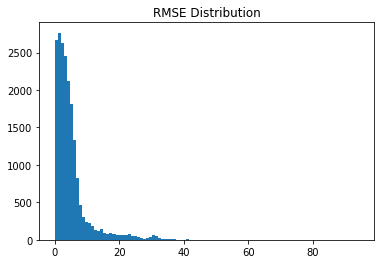

In [15]:
def print_evaluation(y_obs, y_pred, max_lim_y=100, return_errors=True):
    rmse_hist = np.sqrt((y_pred - y_obs)**2)
    plt.hist(rmse_hist[y_obs < max_lim_y], bins=100)
    plt.title('RMSE Distribution');

    if(return_errors == True):
        return mae_hist

#####
rmse = np.sqrt(mean_squared_error(df_test_1[TARGET], y_test_pred_1))
iteration_results['exp_1_rmse'] = rmse
print(f'RMSE: {rmse}')

print_evaluation(df_test_1[TARGET], y_test_pred_1, return_errors=False)

## Experimenting on different types of distance
### Haversine - Explain
### Great Circle - Explain


In [16]:
def lat_longs2radians(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    return lon1, lat1, lon2, lat2

def haversine_distance(lat1, lat2, lon1, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = lat_longs2radians(lon1, lat1, lon2, lat2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# TODO: manhattan with lat lon has NOT worked - see attempt below
# def manhattan_distance(lon1, lat1, lon2, lat2):
#   lon1, lat1, lon2, lat2 = lat_longs2radians(lon1, lat1, lon2, lat2)
#   dlon = np.abs(lon2 - lon1)
#   dlat = np.abs(lat2 - lat1)
#   return dlon + dlat

df_train_temp = df_train.head(3).copy()
df_train_temp['haversine_dist'] = haversine_distance(df_train_temp['pickup_latitude'], df_train_temp['dropoff_latitude'], 
                                                   df_train_temp['pickup_longitude'], df_train_temp['dropoff_longitude'])


# df_train_temp['manhattan_dist'] = manhattan_distance(df_train_temp['pickup_latitude'], df_train_temp['dropoff_latitude'], 
#                                                    df_train_temp['pickup_longitude'], df_train_temp['dropoff_longitude'])

df_train_temp


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine_dist
74164,2009-03-28 17:14:03,-73.99483,40.745525,-73.96762,40.792683,3,12.9,5.718942
48063,2014-05-11 17:24:02,-73.98030,40.776190,-73.94921,40.805153,1,13.0,4.147373
73757,2013-03-08 15:07:00,-73.97310,40.780320,-73.98011,40.765630,1,7.0,1.735753


In [17]:
# trying to convert to UTM and use traditional euclidean space to calculate manhattan BUT IT DIDN'T WORK



# from pyproj import Proj, transform

# inProj = Proj(init='epsg:4326')  # lat lon
# outProj = Proj(init='epsg:3857') # UTM

# lat_pickup_utm, lon_pickup_utm = transform(inProj,outProj,df_train['pickup_latitude'].values, df_train['pickup_longitude'].values)
# lat_dropoff_utm, lon_dropoff_utm = transform(inProj,outProj,df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)

# df_train['manhattan_dist'] = np_manhattan(np.array(lat_pickup_utm), np.array(lat_dropoff_utm), 
#                                           np.array(lon_pickup_utm), np.array(lon_dropoff_utm))

In [18]:
def pre_processing_pipeline_2(df, target_col=TARGET, 
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude'):
    EUCLIDEAN_FEAT = 'euclidean_dist'
    HAVERSINE_FEAT = 'haversine_dist'
    # MANHATTAN_FEAT = 'manhattan_dist'
    FEATURES = [EUCLIDEAN_FEAT, HAVERSINE_FEAT] #, MANHATTAN_FEAT - #not returning MANHATTAN_FEAT because it's wrong

    df_copy = df.copy()

    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    df_copy[HAVERSINE_FEAT] = haversine_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    # df_copy[MANHATTAN_FEAT] = manhattan_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
    #                                         df_copy[pickup_longitude], df_copy[dropoff_longitude])

    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()

    df_res = standardize_features(df_copy[FEATURES])
    df_res[target_col] = df_copy[target_col]
    return df_res

df_train_2 = pre_processing_pipeline_2(df_train)
df_test_2 = pre_processing_pipeline_2(df_test)


In [19]:
model_2 = LinearRegression()
model_2.fit(df_train_2.drop(TARGET, axis=1), df_train_2[TARGET])

y_test_pred_2 = model_2.predict(df_test_2.drop(TARGET, axis=1))

RMSE Error: 4.824386076977735


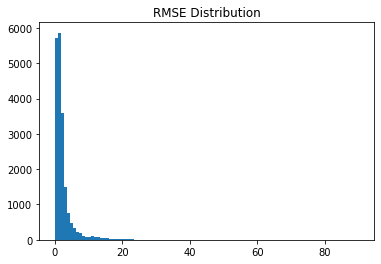

In [20]:
rmse_2 = np.sqrt(mean_squared_error(df_test_2[TARGET], y_test_pred_2))
iteration_results['exp_2_rmse'] = rmse_2
print(f'RMSE Error: {rmse_2}')

print_evaluation(df_test_2[TARGET], y_test_pred_2, return_errors=False)

In [21]:
iteration_results

{'exp_1_rmse': 8.248415628735593, 'exp_2_rmse': 4.824386076977735}

# Creating a router - OSRM Router

## Setup

Setting local docker image for ORSM back-end - https://hub.docker.com/r/osrm/osrm-backend/

* wget http://download.geofabrik.de/north-america/us/new-york-latest.osm.pbf (file is ~200 Mb)

* Move file to your project folder

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-partition /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-customize /data/new-york-latest.osm.pbf

* docker run -t -i -p 5000:5000 -v "${PWD}:/data" osrm/osrm-backend osrm-routed --algorithm mld /data/new-york-latest.osm.pbf

Example latitude longitude New York: `-73.996070,40.732605;-73.980675,40.761864`

Test: `curl "http://localhost:5000/route/v1/driving/-73.996070,40.732605;-73.980675,40.761864?steps=false&geometries=geojson&annotations=true"`

## Calculate street distances and durations

In [22]:
lat1, lon1 = 40.732605,-73.996070
lat2, lon2 = 40.761864,-73.980675

osm = OSRMFramework('localhost:5000')
lat, lon, distance, duration, node_ids = osm.route(lat1, lon1, lat2, lon2)

t = latlon2linestring(lat, lon)

plot_linestring(t)

In [23]:
def get_route(osm, lat1, lon1, lat2, lon2):
    lat, lon, distance, duration, node_ids = osm.route(lat1, lon1, lat2, lon2)
    return_col_names = ['route', 'distance_m', 'duration_sec']
    if(type(lat) == float):
        return pd.Series([np.nan,np.nan,np.nan], index=return_col_names)
    else:
        return pd.Series([latlon2linestring(lat, lon), distance, duration], index=return_col_names)

routes = df_train.head().apply(lambda row: get_route(osm, 
                                            row['pickup_latitude'],
                                            row['pickup_longitude'],
                                            row['dropoff_latitude'],
                                            row['dropoff_longitude']), axis=1)

routes

,route,distance_m,duration_sec
74164,"0 LINESTRING (-73.99483000000001 40.745525,...",7848.2,585.3
48063,"0 LINESTRING (-73.9803 40.77619, -73.980219...",4796.8,448.6
73757,"0 LINESTRING (-73.9731 40.78032, -73.973 40...",2163.5,229.1
85609,"0 LINESTRING (-73.973145 40.792656, -73.973...",2511.7,194.1
24835,"0 LINESTRING (-73.97198 40.7496, -73.971903...",2936.9,272.6


In [24]:
%%time

def pre_processing_pipeline_3(df, target_col=TARGET, 
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude',
                              osm_router=OSRM_PATH,
                              test_mode=None):
    EUCLIDEAN_FEAT = 'euclidean_dist'
    HAVERSINE_FEAT = 'haversine_dist'
    # MANHATTAN_FEAT = 'manhattan_dist'
    ROUTE_DISTANCE = 'route_distance_meters'
    ROUTE_DURATION = 'route_duration_seconds'
    
    FEATURES = [EUCLIDEAN_FEAT, 
                HAVERSINE_FEAT, #, MANHATTAN_FEAT - #not returning MANHATTAN_FEAT because it's wrong
                ROUTE_DISTANCE,
                ROUTE_DURATION] 

    df_copy = df.copy()

    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    df_copy[HAVERSINE_FEAT] = haversine_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    # df_copy[MANHATTAN_FEAT] = manhattan_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
    #                                         df_copy[pickup_longitude], df_copy[dropoff_longitude])
    
    if(test_mode == 'train'):                                                          # TEST MODE
        with open('data/temp_routes_train.pickle', 'rb') as f:                         # TEST MODE
            routes = pickle.load(f)                                                    # TEST MODE
    elif(test_mode == 'test'):                                                         # TEST MODE
        with open('data/temp_routes_test.pickle', 'rb') as f:                          # TEST MODE
            routes = pickle.load(f)                                                    # TEST MODE   
        
#     routes = df_copy.apply(lambda row: get_route(osm, 
#                                             row['pickup_latitude'],
#                                             row['pickup_longitude'],
#                                             row['dropoff_latitude'],
#                                             row['dropoff_longitude']), axis=1)

#     routes['route'] = GeoSeries([elem[0] if type(elem) == GeoSeries else np.nan for elem in routes['route']], index=routes.index)
    df_copy[ROUTE_DISTANCE] = routes['distance_m']
    df_copy[ROUTE_DURATION] = routes['duration_sec']
    
    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()

    df_res = standardize_features(df_copy[FEATURES])
    df_res[target_col] = df_copy[target_col]
    return df_res, routes

df_train_3, routes_train = pre_processing_pipeline_3(df_train, test_mode='train')
df_test_3, routes_test = pre_processing_pipeline_3(df_test, test_mode='test')


##### Save locally when executting OSRM
# with open('data/temp_routes_train.pickle', 'wb') as f:
#     pickle.dump(routes_train, f)
    
# with open('data/temp_routes_test.pickle', 'wb') as f:
#     pickle.dump(routes_test, f)

CPU times: user 1.02 s, sys: 134 ms, total: 1.16 s
Wall time: 1.42 s


In [25]:
model_3 = LinearRegression()
model_3.fit(df_train_3.drop(TARGET, axis=1), df_train_3[TARGET])
y_test_pred_3 = model_3.predict(df_test_3.drop(TARGET, axis=1))


RMSE Error: 4.6630417979918555


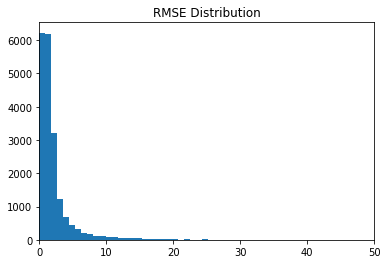

In [26]:
#####
rmse_3 = np.sqrt(mean_squared_error(df_test_3[TARGET], y_test_pred_3))
iteration_results['exp_3_rmse'] = rmse_3
print(f'RMSE Error: {rmse_3}')

print_evaluation(df_test_3[TARGET], y_test_pred_3, return_errors=False)
plt.xlim([0, 50]);

In [27]:
iteration_results

{'exp_1_rmse': 8.248415628735593,
 'exp_2_rmse': 4.824386076977735,
 'exp_3_rmse': 4.6630417979918555}

# 2nd Exploratory Analysis

## Check why we have some route distance == 0

In [28]:
df_train_3_analysis = df_train_3.merge(df_train, how='left', left_index=True, right_index=True)

df_train_3_analysis['route_distance_km'] = routes_train['distance_m']/1000
display(df_train_3_analysis.loc[df_train_3_analysis['route_distance_km'] == 0].head()) # PROBLEM pickup == dropoff

##########################################################
### Filter where pick up and drop off are the same
##########################################################


# df_train = df_train.loc[(df_train['pickup_latitude'] != df_train['dropoff_latitude']) & 
#                         (df_train['pickup_longitude'] != df_train['dropoff_longitude'])]


,euclidean_dist,haversine_dist,route_distance_meters,route_duration_seconds,fare_amount_x,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_y,route_distance_km
39479,0.903316,-1.000831,-0.997808,-1.38656,4.0,2012-10-22 21:02:44,-73.982330,40.774227,-73.982330,40.774227,1,4.0,0.0
79577,-0.558625,-1.000831,-0.997808,-1.38656,3.5,2012-09-13 01:13:00,-73.987640,40.721405,-73.987640,40.721405,6,3.5,0.0
16534,0.020804,-1.000831,-0.997808,-1.38656,6.5,2014-01-30 20:36:42,-73.996640,40.731236,-73.996640,40.731236,1,6.5,0.0
95731,0.431921,-1.000831,-0.997808,-1.38656,5.7,2012-07-27 19:41:00,-73.986030,40.755207,-73.986030,40.755207,1,5.7,0.0
55237,0.581432,-1.000831,-0.997808,-1.38656,15.5,2013-07-18 11:04:00,-73.986626,40.759470,-73.986626,40.759470,3,15.5,0.0


## Some leftover routes still have route_distance == 0, investigate

In [29]:
df_train_3_analysis = df_train_3_analysis.loc[df_train.index]

df_train_3_analysis['distances'] = haversine_distance(df_train_3_analysis['pickup_latitude'], df_train_3_analysis['dropoff_latitude'],
                               df_train_3_analysis['pickup_longitude'], df_train_3_analysis['dropoff_longitude'])

df_train_3_analysis.loc[df_train_3_analysis['route_distance_km'] == 0].head() ### ?? - ~65 examples

##########################################################
### Filter where route_distance == 0 for next iteration###
##########################################################



,euclidean_dist,haversine_dist,route_distance_meters,route_duration_seconds,fare_amount_x,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_y,route_distance_km,distances
39479,0.903316,-1.000831,-0.997808,-1.38656,4.0,2012-10-22 21:02:44,-73.982330,40.774227,-73.982330,40.774227,1,4.0,0.0,0.0
79577,-0.558625,-1.000831,-0.997808,-1.38656,3.5,2012-09-13 01:13:00,-73.987640,40.721405,-73.987640,40.721405,6,3.5,0.0,0.0
16534,0.020804,-1.000831,-0.997808,-1.38656,6.5,2014-01-30 20:36:42,-73.996640,40.731236,-73.996640,40.731236,1,6.5,0.0,0.0
95731,0.431921,-1.000831,-0.997808,-1.38656,5.7,2012-07-27 19:41:00,-73.986030,40.755207,-73.986030,40.755207,1,5.7,0.0,0.0
55237,0.581432,-1.000831,-0.997808,-1.38656,15.5,2013-07-18 11:04:00,-73.986626,40.759470,-73.986626,40.759470,3,15.5,0.0,0.0


## Check price per kilometer

In [30]:
temp = df_train_3_analysis.loc[df_train_3_analysis['route_distance_km'] != 0]

price_km = temp['fare_amount_y']/temp['route_distance_km']
display(price_km.describe(percentiles=[.9, .95, .99]))

##########################################################
### Filter where price per km > 5 - 95th percentile    ###
##########################################################


# df_train = df_train.loc[price_km < 5]

count     76347.000000
mean         65.618609
std        4399.558466
min           0.140470
50%           2.862484
90%           4.826571
95%           5.863738
99%          11.023648
max      498000.000000
dtype: float64

# Embed taxi rules - https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

# Embed Nearest neighboors fares

In [31]:
from sklearn.neighbors import KNeighborsRegressor

In [56]:
for i in range(20):

    n = df_train.merge(df_train_3, how='left', left_index=True, right_index=True)

    n['minutes_since_monday_midnight'] = n['pickup_datetime'].dt.dayofweek * (24*60) + n['pickup_datetime'].dt.hour * 60 + n['pickup_datetime'].dt.minute

    #### 
    n_filtered = standardize_features(n[['pickup_latitude', 'pickup_longitude', 
       'dropoff_latitude', 'dropoff_longitude', 
       'minutes_since_monday_midnight']])

    avg_fare = KNeighborsRegressor(n_neighbors=i+1)
    avg_fare.fit(n_filtered, n['fare_amount_x'])

    df_train_3['avg_fare'] = avg_fare.predict(n_filtered)

    ####
    ####

    n = df_test.merge(df_test_3, how='left', left_index=True, right_index=True)

    n['minutes_since_monday_midnight'] = n['pickup_datetime'].dt.dayofweek * (24*60) + n['pickup_datetime'].dt.hour * 60 + n['pickup_datetime'].dt.minute

    #### 
    n_filtered = standardize_features(n[['pickup_latitude', 'pickup_longitude', 
       'dropoff_latitude', 'dropoff_longitude', 
       'minutes_since_monday_midnight']])

    df_test_3['avg_fare'] = avg_fare.predict(n_filtered)




    model_4 = LinearRegression()
    model_4.fit(df_train_3.drop(TARGET, axis=1), df_train_3[TARGET])
    y_test_pred_4 = model_4.predict(df_test_3.drop(TARGET, axis=1))


    #####
    rmse_4 = np.sqrt(mean_squared_error(df_test_3[TARGET], y_test_pred_4))
    iteration_results['exp_4_rmse'] = rmse_4
    print(f'RMSE Error {i}: {rmse_4}')

    # print_evaluation(df_test_3[TARGET], y_test_pred_4, return_errors=False)
    # plt.xlim([0, 50]);

RMSE Error 0: 5.565394371020664
RMSE Error 1: 5.004482181284339
RMSE Error 2: 4.765520571638066
RMSE Error 3: 4.654067349364686
RMSE Error 4: 4.582193259913836
RMSE Error 5: 4.547000435405514
RMSE Error 6: 4.510028332832027
RMSE Error 7: 4.464920765648378
RMSE Error 8: 4.4547714454037886
RMSE Error 9: 4.459550495563357
RMSE Error 10: 4.452969133725542
RMSE Error 11: 4.460782699619377
RMSE Error 12: 4.463670818061193
RMSE Error 13: 4.464705778805495
RMSE Error 14: 4.468552086568111
RMSE Error 15: 4.469166311305178
RMSE Error 16: 4.469148020954785
RMSE Error 17: 4.467049133961367
RMSE Error 18: 4.471118397635968
RMSE Error 19: 4.468989134078184


RMSE Error 19: 4.459550495563357


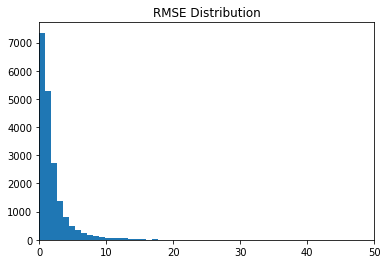

In [57]:
n = df_train.merge(df_train_3, how='left', left_index=True, right_index=True)

n['minutes_since_monday_midnight'] = n['pickup_datetime'].dt.dayofweek * (24*60) + n['pickup_datetime'].dt.hour * 60 + n['pickup_datetime'].dt.minute

#### 
n_filtered = standardize_features(n[['pickup_latitude', 'pickup_longitude', 
   'dropoff_latitude', 'dropoff_longitude', 
   'minutes_since_monday_midnight']])

avg_fare = KNeighborsRegressor(n_neighbors=10)
avg_fare.fit(n_filtered, n['fare_amount_x'])

df_train_3['avg_fare'] = avg_fare.predict(n_filtered)

####
####

n = df_test.merge(df_test_3, how='left', left_index=True, right_index=True)

n['minutes_since_monday_midnight'] = n['pickup_datetime'].dt.dayofweek * (24*60) + n['pickup_datetime'].dt.hour * 60 + n['pickup_datetime'].dt.minute

#### 
n_filtered = standardize_features(n[['pickup_latitude', 'pickup_longitude', 
   'dropoff_latitude', 'dropoff_longitude', 
   'minutes_since_monday_midnight']])

df_test_3['avg_fare'] = avg_fare.predict(n_filtered)




model_4 = LinearRegression()
model_4.fit(df_train_3.drop(TARGET, axis=1), df_train_3[TARGET])
y_test_pred_4 = model_4.predict(df_test_3.drop(TARGET, axis=1))


#####
rmse_4 = np.sqrt(mean_squared_error(df_test_3[TARGET], y_test_pred_4))
iteration_results['exp_4_rmse'] = rmse_4
print(f'RMSE Error: {rmse_4}')

print_evaluation(df_test_3[TARGET], y_test_pred_4, return_errors=False)
plt.xlim([0, 50]);

In [58]:
iteration_results

{'exp_1_rmse': 8.248415628735593,
 'exp_2_rmse': 4.824386076977735,
 'exp_3_rmse': 4.6630417979918555,
 'exp_4_rmse': 4.459550495563357}